In [ ]:
import numpy as np
import cv2
from skimage.segmentation import slic
from skimage.color import label2rgb
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

In [ ]:
# Шаг 1: Загрузка изображения
image_path = 'data\800px-Lenna.png'  # путь к изображению
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [ ]:
# Этап а): Грубая иерархия связных сегментов (SLIC)
n_segments = 23000  # Количество начальных сегментов
segments = slic(image, n_segments=n_segments, compactness=10, start_label=1)

# Преобразование сегментов в суперпиксели
superpixel_means = [] # пустой список для хранения средних значений цвета каждого суперпикселя.
superpixel_coords = [] # пустой список для хранения средних координат каждого суперпикселя.
unique_segments = np.unique(segments) # получить уникальные значения в массиве segments. Это будут метки сегментов, которые были получены при помощи SLIC.
for seg_val in unique_segments: # Запускаем цикл по всем уникальным сегментам
    mask = segments == seg_val
    superpixel_means.append(image[mask].mean(axis=0))  # Среднее значение цвета
    coords = np.column_stack(np.where(mask))          # Собираем координаты пикселей в массив
    superpixel_coords.append(coords.mean(axis=0))     # Средние координаты, это дает средние координаты сегмента

superpixel_means = np.array(superpixel_means) # Преобразует список средних значений цветов каждого сегмента в массив NumPy для дальнейшей обработки.
superpixel_coords = np.array(superpixel_coords) # Преобразует список средних координат в массив NumPy для дальнейшей обработки.

# Объединение признаков: цвет + координаты
spatial_weight = 0.1  # Вес пространственных координат, vалое значение указывает на то, что цветовые признаки будут важнее, чем пространственные
# Используется для объединения признаков цвета и пространственных координат в один массив признаков для каждого суперпикселя.
superpixel_features = np.hstack((superpixel_means, spatial_weight * superpixel_coords))
# В результате, каждый суперпиксель будет представлен в виде вектора признаков,
# который состоит из средних значений цвета и средних координат, умноженных на соответствующий вес.

In [ ]:
# Этап б): Кластеризация суперпикселей методом K-meanless
def k_meanless_superpixels(features, n_superpixels, max_iter=10):
    """
    Реализация метода K-meanless для суперпикселей.
    Args:
        features: ndarray, признаки пикселей (цвет + координаты).
        n_superpixels: int, желаемое число суперпикселей.
        max_iter: int, максимальное количество итераций.
    Returns:
        labels: ndarray, метки кластеров для каждого пикселя.
    """
    np.random.seed(42)
    # Инициализация центроидов случайным образом
    # Cлучайным образом выбираются n_superpixels индексов из массива features. Это будут индексы, по которым будут инициализированы центроиды.
    indices = np.random.choice(features.shape[0], n_superpixels, replace=False)
    centroids = features[indices]

    # В каждой итерации будет происходить пересчет меток кластеров и обновление центроидов.
    for iteration in range(max_iter):
        # Шаг 1: Назначение пикселей ближайшему центроиду
        distances = euclidean_distances(features, centroids) # вычисляет евклидово расстояние между каждым пикселем (его признаками) и каждым из центроидов.
        labels = np.argmin(distances, axis=1) # Для каждого пикселя выбирается индекс ближайшего центроида

        # Шаг 2: Обновление центроидов как среднее для каждого кластера
        # новый массив для центроидов , который имеет такую же форму,
        # как и массив старых центроидов (centroids), но с нулевыми значениями.
        new_centroids = np.zeros_like(centroids)
        for i in range(n_superpixels):
            cluster_points = features[labels == i] # Для каждого кластера с индексом i выбираются все пиксели, принадлежащие этому кластеру.
            if len(cluster_points) > 0:
            # Если в текущем кластере есть хотя бы один пиксель, то центроид
            # этого кластера обновляется как среднее значение всех пикселей, принадлежащих этому кластеру.
                new_centroids[i] = cluster_points.mean(axis=0)
            else:
                # Если кластер пустой, оставляем старый центроид
                new_centroids[i] = centroids[i]

        # Проверка сходимости, не изменились ли центроиды после обновления
        # Это сравнение выполняется с точностью до 1e-4
        if np.allclose(centroids, new_centroids, atol=1e-4):
            break

        # обновление стапрых центроидов на новые
        centroids = new_centroids
    # Функция возвращает массив меток кластеров для каждого пикселя.
    # Каждый пиксель будет иметь метку того суперпикселя (кластера), к которому он принадлежит.
    return labels

# Применение K-meanless метода
n_superpixels = 100  # Задаем количество суперпикселей
labels = k_meanless_superpixels(superpixel_features, n_superpixels)

# Обновление сегментов на основе K-meanless кластеризации
segmented_image = np.zeros_like(segments, dtype=np.int32)
for idx, label in enumerate(unique_segments):
    segmented_image[segments == label] = labels[idx]

In [ ]:
# Этап в): Финальная кластеризация суперпикселей методом Уорда
final_n_clusters = 2  # Итоговое количество кластеров
# linkage='ward': Устанавливает метод агломерации, который будет использоваться для объединения кластеров.
# В данном случае используется метод Уорда, который минимизирует увеличение суммы квадратов отклонений внутри кластера при объединении.
final_clustering = AgglomerativeClustering(n_clusters=final_n_clusters, linkage='ward')
final_labels = final_clustering.fit_predict(superpixel_features)

# Обновление сегментов на основе финальной кластеризации
final_segmented_image = np.zeros_like(segments, dtype=np.int32)
for idx, label in enumerate(unique_segments):
    final_segmented_image[segments == label] = final_labels[idx]

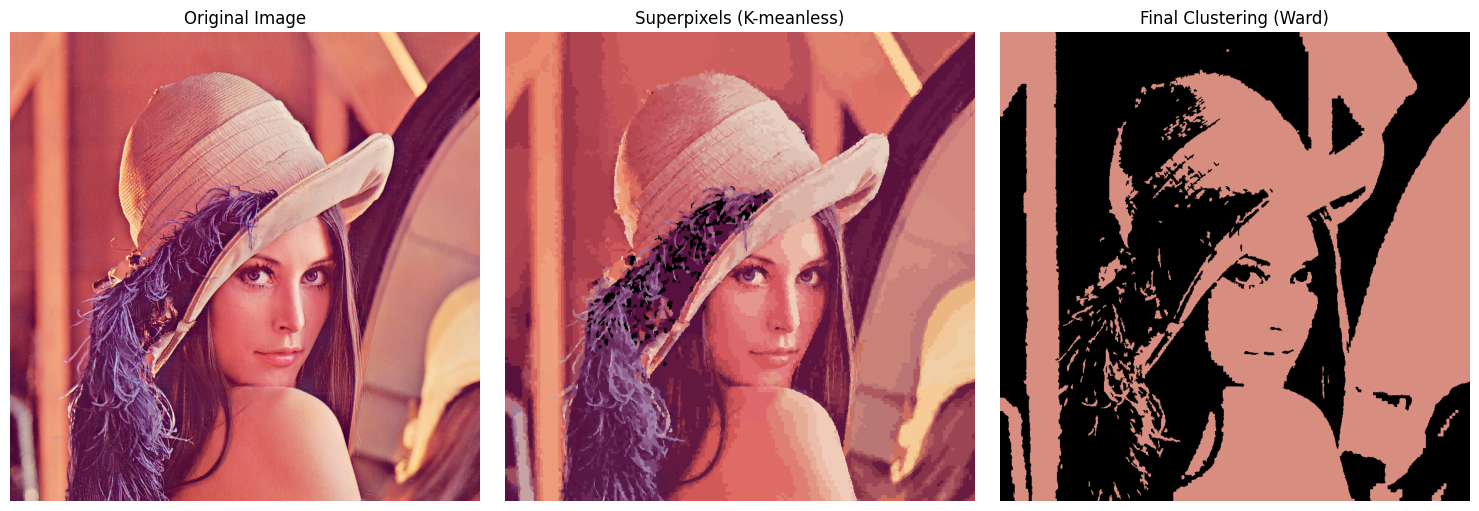

In [ ]:
# Визуализация результата
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(label2rgb(segmented_image, image, kind='avg'))
axes[1].set_title('Superpixels (K-meanless)')
axes[1].axis('off')

axes[2].imshow(label2rgb(final_segmented_image, image, kind='avg'))
axes[2].set_title('Final Clustering (Ward)')
axes[2].axis('off')

plt.tight_layout()
plt.show()